### 3 WAYS IMPLEMENT DEEP LEARNING MODEL IN KERAS USING TF2.X

- Co ba cach de thuc hien mot model deeplearning tren thu vien Keras voi backend la Tensorflow 2.0
- Ba cach do la: Sequential, Functional API, va Model Subclassing


### 1. Sequential

CONV --> BATCH NORM --> RELU

Keras Sequential API la cach don gian nhat de thiet ke mo hinh machinelearning/ deep learning. Chinh vi su don gian de su dung cua phuong phap Sequential ma no cung bi han che rat nhieu va chung ta khong the thiet ke trong cac truong hop sau.

- Muon thiet ke dung chung layer
- Model co nhanh
- Co nhieu inputs
- Co nhieu outputs



In [21]:
#import cac packages can thiet cho thiet ke
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

De thuc hien model bang Sequential API, tat nhien chung ta phai import class Sequential tu package layers trong tensorflow.

- Tao model instance(object)
- Them lan luot cac layer, mot layer mot lan (one layer a time)
- Trong vi du duoi ```my_sequential model``` chua mot layer ```CONV-RELU``` va theo sau la mot ```softmax classifier```
- Khi kien truc model da duoc xay dung nhu mong muon, chung ta se tra ve object model vua tao de co the complited sau do

In [22]:
def my_sequential(width, height, depth, classes):
    # khoi tao model voi sequential ()
    # khoi tao kich thuoc input (height, width, depth)
    model = Sequential()
    inputShape = (height, width, depth)
    
    # them layer dau tien vao model
    model.add(Conv2D(32, (3,3), padding="same", input_shape = inputShape)) #CONV
    model.add(Activation("relu"))                                          #RELU
    
    # them soft-max classifier block bao gom (Fallten, Dense, softmax)
    model.add(Flatten())                                                   #FLATTEN
    model.add(Dense(classes))                                              #DENSE
    model.add(Activation("softmax"))                                       #SOFT-MAX
    
    # tra ve model vua dc thiet ke
    return model
    

#### Example

In [23]:
sequential_model = my_sequential(32,32,3,4)

In [24]:
#show architecture of sequential_model
sequential_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_50 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 131076    
_________________________________________________________________
activation_51 (Activation)   (None, 4)                 0         
Total params: 131,972
Trainable params: 131,972
Non-trainable params: 0
_________________________________________________________________


### 2. Functional API

           |----> CONV (size=3x3, stride = 2x2) --->|
 - INPUT --|                                        |---->CONCATENATE
           |----> POOL (size=3x3, stride =2x2)  --->|
           



Chung ta co the su dung Functional API de:

- Tao model phuc tap hon binh thuong
- Tao model voi nhieu inputs va nhieu outputs
- De dang dinh nghia nhanh trong kien truc model (vi du nhu Inception block, ResNet block, ...)
- Thiet ke Directed Acyclic Graphs (DAGs)
- De dang chia se Layer dung chung trong kien truc

Hon nua bat ky model Sequential nao cung co the tao dc tu functional API.

Mot so vi du ve model co tinh caht Funcational (model chua nhanh) bao gom:

- ResNet
- GooLeNEt/Inception
- Xception
- SqueezeNet

- ```conv_module```: Thuc hien convolution tren dau vao, xu dung Batch normalization va sau do ap dung Reclu activation. Chung ta se dinh nghai module nay de co the su dung nhieu lan.
- ```inception_module``` : Khoi tao tu 2 module tren ```conv_module```. Conv module dau tien thi su dung 1x1 kernel trong conv thu hai su dung 3x3 kernel cho convolution. Su dung 'same' padding de dam bao la output size cua 1x1 va 3x3 la cung kich thuoc. Boi vi output volumns sau do duoc cancatenated voi nhau theo chieu channel.
- ```Downsample Module```: Module co nhiem vu de giam kich thuoc cua unout. Tuong tu nhu inception_module co hai nhanh o module nay. Nhanh thu nhat su dung 3x3 convolution 2x2 stride va 'valid' padding de giup giam kich thuoc dau ra. Nhanh thu2 la 3x3 maxpooling voi 2x2 stride. Tat nhien output cua 2 nhanh se dong nhat voi nhau va co the concatenate voi nhau theo channel.

In [25]:
def minigooglenet_functional(width, height, depth, classes):
    def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
        #define a CONV=>BN=>RelU pattern
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        
        #return the block
        return x;
    
    def inception_module(x, numK1x1, numK3x3, chanDim):
        #define two Conv modules, then concate across the channel dimension
        conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim) #branch1 perform 1x1 convolution
        conv_3x3 = conv_module(x, numK3x3, 3,3, (1, 1), chanDim)  #branch2 perform 3x3 convolution
        x = concatenate([conv_1x1, conv_3x3], axis=chanDim)       #concate two brach in channel axis
        
        # return the block
        return x
    
    def downsample_module(x, K, chanDim):
        #define the conv module and pool the concate them accross the channel dimension
        conv_3x3 = conv_module(x, K, 3,3, (2,2),
                               chanDim, padding="valid") #first branch perform 3x3 convolution with 2x2 stride
        pool = MaxPooling2D((3,3), strides=(2,2))(x)     #second branch perform 3x3 max-pooling with 2x2 stride
        x = concatenate([conv_3x3, pool], axis=chanDim)
        
        #return block
        return x
    
    # initialize the input shape to be "channel last" and the channel dimension it self
    inputShape = (height, width, depth)
    chanDim = -1
    
    #define the model input and first CONV module
    inputs = Input(shape=inputShape)
    x = conv_module(inputs, 96, 3,3, (1,1), chanDim)
    
    #two inception module followed by a downsample module
    x = inception_module(x, 32, 32, chanDim)
    x = inception_module(x, 32, 48, chanDim)
    x = downsample_module(x, 80, chanDim)
    
    # four Inception module followed by a downsample module
    x = inception_module(x, 112, 48, chanDim)
    x = inception_module(x, 96, 64, chanDim)
    x = inception_module(x, 80, 80, chanDim)
    x = inception_module(x, 48, 96, chanDim)
    x = downsample_module(x, 96, chanDim)
    
    #two Inception module followed by global Pool and dropout
    x = inception_module(x, 176, 160, chanDim)
    x = inception_module(x, 176, 160, chanDim)
    x = AveragePooling2D((7,7))(x)
    x = Dropout(0.5)(x)
    
    #softmax classifier
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)
    
    # create the model
    model = Model(inputs, x, name="minigooglenet")
    return model

#### An example

In [26]:
functional_model = minigooglenet_functional(width=32, height=32, depth=4, classes=10)
functional_model.summary()

Model: "minigooglenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 32, 32, 96)   3552        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 32, 32, 96)   384         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 32, 32, 96)   0           batch_normalization_43[0][0]     
______________________________________________________________________________________

### 3. Model Subclassing

Cach thu 3 de thuc hien mot deep learning model la su dung Model Subclassing. Thu vien Keras thi Model la root class duoc su dung define cac kien truc model khac. Keras tan dung kieu lap trinh huong doi tuong.

Cach thu 3 nay giup chung ta co the tuy bien toi da de thuc hien model va forward propagation trong network model.

Chinh su can thiep nay lam cho viec su dung cach thu 3 nay tro nen kho hon so voi 2 cach o tren (Functional APi vaf Sequential API)

In [27]:
class MiniVGGNetModel(Model):
    def __init__(self, classes, chanDim =-1):
        #call the parent constructor
        super(MiniVGGNetModel, self).__init__()
        
        # initialize the layer in the fist (conv=>relu)*2=>pool
        # layer set
        self.conv1A = Conv2D(32, (3,3), padding="same")
        self.act1A = Activation("relu")
        self.bn1A = BatchNormalization(axis=chanDim)
        self.conv1B = Conv2D(32, (3,3), padding="same")
        self.act1B = Activation("relu")
        self.bn1B = BatchNormalization(axis=chanDim)
        self.poo1 = MaxPooling2D(pool_size=(2,2))
        
        #initialie the layer in the second (CONV=> RELU)*2 => POOL
        self.conv2A = Conv2D(32, (3,3), padding="same")
        self.act2A = Activation("relu")
        self.bn2A = BatchNormalization(axis=chanDim)
        self.conv2B = Conv2D(32, (3,3), padding="same")
        self.act2B = Activation("relu")
        self.bn2B = BatchNormalization(axis=chanDim)
        self.pool2 = MaxPooling2D(pool_size=(2,2))
        
        #initiaize the layer in our fully-connected layer set
        self.flatten = Flatten()
        self.dense3 = Dense(512)
        self.act3 = Activation("relu")
        self.bn3 = BatchNormalization()
        self.do3 = Dropout(0.5)
        
        #initialize the layer in the softmax classifier set
        self.dense4 = Dense(classes)
        self.softmax = Activation("softmax")
        
    #Khi ma Keras layer va cac layer tuy bien duoc dinh nghia ching ta se dinh ngia networl topology
    #hay goi la graph o trong ham call function => forward pass
    def call(self, inputs):
        #build the first (conv=> relu)*2 => pool layer set
        x = self.conv1A(inputs)
        x = self.act1A(x)
        x = self.bn1A(x)
        x = self.conv1B(x)
        x = self.act1B(x)
        x = self.act1B(x)
        x = self.bn1B(x)
        x = self.poo1(x)
        
        # build the second (CONV=>RELU) *2 =>POOL
        x = self.conv2A(x)
        x = self.act2A(x)
        x = self.bn2A(x)
        x = self.conv2B(x)
        x = self.act2B(x)
        x = self.bn2B(x)
        x = self.pool2(x)
        
        #build our FC layer set
        x = self.flatten(x)
        x = self.dense3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.do3(x)
        
        #build the softmax classifier
        x = self.dense4(x)
        x= self.softmax(x)
        
        #return the constructed model
        return x

#### Implement the training script

In [28]:
# set the matplotlib backend so figure can be saved in the background
import matplotlib.pyplot as plt
#matplotlib.use("Agg")
#matplotlib.use('TkAgg')

import logging
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)

#import the necessary package
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import argparse


ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", type=str, default="sequential",
               choices=["sequential", "functional", "class"],
               help="type of model architecture")
ap.add_argument("-p", "--plot", type=str, required=True,
               help="path to ouput plot file")

#args = vars(ap.parse_args())

_StoreAction(option_strings=['-p', '--plot'], dest='plot', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='path to ouput plot file', metavar=None)

In [29]:
# initialize the initial learning rate, batch size, and number of epochs to train for
INIT_LR = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 60

# initialize the label names for the cifar-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", 
              "dog", "frog", "horse", "ship", "truck"]

# load the cifar-10 dataset
print("[INFO] loadig CIFAR-10 dataset")
((trainX, trainY), (testX, testY)) = cifar10.load_data()

# scale the data to the range [0, 1]
trainX = trainX.astype("float32")/255.0
testX = testX.astype("float32")/255.0

[INFO] loadig CIFAR-10 dataset


In [30]:
# convert the labels from integer to vector
from  sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augumentation
aug = ImageDataGenerator(rotation_range=18, zoom_range=0.15,
                        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")

In [31]:
# # check to see if we are using a Keras Sequential model
# if args["model"] == "sequential":
#     # instantiate a keras sequential model
#     print("[INFO] using sequential model ...")
#     model = my_sequential(32, 32, 3, len(labelNames))
    
# elif args["model"] == "functional":
#     # instantiate a keras functional model
#     print("[INFO] using functional model ...")
#     model = minigooglenet_functional(32,32,3, len(labelNames))
    
# elif args["model"] == "class":
#     # instantiate a keras model sub-classing
#     print("[INFO] using model sub-class ...")
#     model = MiniVGGNetModel(len(labelNames))

In [32]:
# initialize the optimizer and compile the model
model = my_sequential(32, 32, 3, len(labelNames))
opt = SGD(lr=INIT_LR, momentum=0.9, decay = INIT_LR/ NUM_EPOCHS)
print ("[INFO] training network")
model.compile(loss="categorical_crossentropy", optimizer=opt,
            metrics=["accuracy"])

#train the network
# train the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS)

[INFO] training network
Train for 390 steps, validate on 10000 samples
Epoch 1/60
390/390 [==============================] - 29s 74ms/step - loss: 1.8986 - accuracy: 0.3197 - val_loss: 1.6284 - val_accuracy: 0.4242
Epoch 2/60
390/390 [==============================] - 28s 73ms/step - loss: 1.7164 - accuracy: 0.3876 - val_loss: 1.5194 - val_accuracy: 0.4733
Epoch 3/60
390/390 [==============================] - 28s 73ms/step - loss: 1.6291 - accuracy: 0.4161 - val_loss: 1.4841 - val_accuracy: 0.4792
Epoch 4/60
390/390 [==============================] - 28s 72ms/step - loss: 1.5918 - accuracy: 0.4298 - val_loss: 1.4320 - val_accuracy: 0.5026
Epoch 5/60
390/390 [==============================] - 28s 72ms/step - loss: 1.5661 - accuracy: 0.4383 - val_loss: 1.4408 - val_accuracy: 0.4875
Epoch 6/60
390/390 [==============================] - 28s 73ms/step - loss: 1.5477 - accuracy: 0.4490 - val_loss: 1.3784 - val_accuracy: 0.5205
Epoch 7/60
390/390 [==============================] - 28s 73ms/st

390/390 [==============================] - 28s 72ms/step - loss: 1.3329 - accuracy: 0.5294 - val_loss: 1.2022 - val_accuracy: 0.5933
Epoch 58/60
390/390 [==============================] - 28s 72ms/step - loss: 1.3264 - accuracy: 0.5316 - val_loss: 1.2440 - val_accuracy: 0.5818
Epoch 59/60
390/390 [==============================] - 28s 73ms/step - loss: 1.3279 - accuracy: 0.5325 - val_loss: 1.2533 - val_accuracy: 0.5798
Epoch 60/60
390/390 [==============================] - 28s 72ms/step - loss: 1.3284 - accuracy: 0.5308 - val_loss: 1.1811 - val_accuracy: 0.5948


In [33]:
# initialize the optimizer and compile the model
model = minigooglenet_functional(32, 32, 3, len(labelNames))
opt = SGD(lr=INIT_LR, momentum=0.9, decay = INIT_LR/ NUM_EPOCHS)
print ("[INFO] training network")
model.compile(loss="categorical_crossentropy", optimizer=opt,
            metrics=["accuracy"])

#train the network
# train the network
H2 = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS)

[INFO] training network
Train for 390 steps, validate on 10000 samples
Epoch 1/60
390/390 [==============================] - 32s 82ms/step - loss: 1.6205 - accuracy: 0.4086 - val_loss: 1.7734 - val_accuracy: 0.3515
Epoch 2/60
390/390 [==============================] - 29s 75ms/step - loss: 1.2406 - accuracy: 0.5519 - val_loss: 1.2675 - val_accuracy: 0.5620
Epoch 3/60
390/390 [==============================] - 29s 75ms/step - loss: 1.0661 - accuracy: 0.6259 - val_loss: 1.2196 - val_accuracy: 0.5835
Epoch 4/60
390/390 [==============================] - 29s 75ms/step - loss: 0.9660 - accuracy: 0.6614 - val_loss: 0.8753 - val_accuracy: 0.6912
Epoch 5/60
390/390 [==============================] - 29s 75ms/step - loss: 0.8739 - accuracy: 0.6971 - val_loss: 1.1476 - val_accuracy: 0.6566
Epoch 6/60
390/390 [==============================] - 29s 75ms/step - loss: 0.8128 - accuracy: 0.7187 - val_loss: 0.8436 - val_accuracy: 0.7101
Epoch 7/60
390/390 [==============================] - 29s 75ms/st

390/390 [==============================] - 29s 75ms/step - loss: 0.2423 - accuracy: 0.9180 - val_loss: 0.5198 - val_accuracy: 0.8539
Epoch 58/60
390/390 [==============================] - 29s 75ms/step - loss: 0.2427 - accuracy: 0.9162 - val_loss: 0.4202 - val_accuracy: 0.8738
Epoch 59/60
390/390 [==============================] - 29s 76ms/step - loss: 0.2368 - accuracy: 0.9175 - val_loss: 0.5115 - val_accuracy: 0.8537
Epoch 60/60
390/390 [==============================] - 29s 75ms/step - loss: 0.2347 - accuracy: 0.9190 - val_loss: 0.4258 - val_accuracy: 0.8762


In [34]:
# initialize the optimizer and compile the model
model = MiniVGGNetModel(len(labelNames))
opt = SGD(lr=INIT_LR, momentum=0.9, decay = INIT_LR/ NUM_EPOCHS)
print ("[INFO] training network")
model.compile(loss="categorical_crossentropy", optimizer=opt,
            metrics=["accuracy"])

#train the network
# train the network
H3 = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS)

[INFO] training network
Train for 390 steps, validate on 10000 samples
Epoch 1/60
390/390 [==============================] - 30s 77ms/step - loss: 1.8879 - accuracy: 0.3593 - val_loss: 1.4765 - val_accuracy: 0.4650
Epoch 2/60
390/390 [==============================] - 29s 74ms/step - loss: 1.5250 - accuracy: 0.4541 - val_loss: 1.4858 - val_accuracy: 0.4898
Epoch 3/60
390/390 [==============================] - 28s 73ms/step - loss: 1.3883 - accuracy: 0.5011 - val_loss: 1.4818 - val_accuracy: 0.5004
Epoch 4/60
390/390 [==============================] - 29s 74ms/step - loss: 1.2924 - accuracy: 0.5373 - val_loss: 1.1470 - val_accuracy: 0.5980
Epoch 5/60
390/390 [==============================] - 29s 73ms/step - loss: 1.2154 - accuracy: 0.5645 - val_loss: 1.2958 - val_accuracy: 0.5474
Epoch 6/60
390/390 [==============================] - 29s 74ms/step - loss: 1.1726 - accuracy: 0.5790 - val_loss: 1.4502 - val_accuracy: 0.5603
Epoch 7/60
390/390 [==============================] - 29s 74ms/st

390/390 [==============================] - 29s 73ms/step - loss: 0.6887 - accuracy: 0.7583 - val_loss: 0.6477 - val_accuracy: 0.7834
Epoch 58/60
390/390 [==============================] - 28s 73ms/step - loss: 0.6955 - accuracy: 0.7574 - val_loss: 0.6271 - val_accuracy: 0.7856
Epoch 59/60
390/390 [==============================] - 29s 74ms/step - loss: 0.6921 - accuracy: 0.7591 - val_loss: 0.6255 - val_accuracy: 0.7863
Epoch 60/60
390/390 [==============================] - 29s 74ms/step - loss: 0.6911 - accuracy: 0.7578 - val_loss: 0.6554 - val_accuracy: 0.7829


#### Evaluate our model and plotting the training history

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.77      0.86      0.81      1000
  automobile       0.82      0.95      0.88      1000
        bird       0.76      0.68      0.72      1000
         cat       0.70      0.52      0.60      1000
        deer       0.82      0.72      0.77      1000
         dog       0.82      0.60      0.69      1000
        frog       0.66      0.93      0.78      1000
       horse       0.84      0.83      0.84      1000
        ship       0.93      0.83      0.88      1000
       truck       0.76      0.91      0.82      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



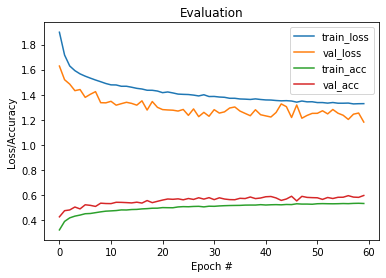

In [35]:
from sklearn.metrics import classification_report
# evaluate the network
print ("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
                           predictions.argmax(axis=1), target_names = labelNames))

#detemine the number of epoch and the construct the plot title
N = np.arange(0, NUM_EPOCHS)
#title = "Training Loss and Accuracy on COFAR-10 ({})".args["model"]

#plot the training losss and accuracy
#plt.style.use("ggplot")
#plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Evaluation")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("evaluation.png")
plt.show()

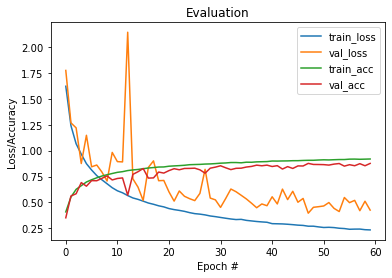

In [36]:
#plt.figure()
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.plot(N, H2.history["accuracy"], label="train_acc")
plt.plot(N, H2.history["val_accuracy"], label="val_acc")
plt.title("Evaluation")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("evaluation.png")
plt.show()

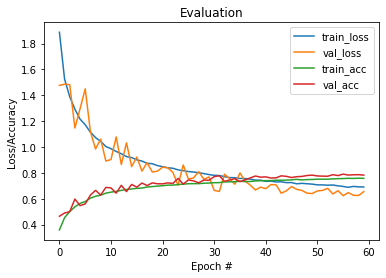

In [37]:
#plt.figure()
plt.plot(N, H3.history["loss"], label="train_loss")
plt.plot(N, H3.history["val_loss"], label="val_loss")
plt.plot(N, H3.history["accuracy"], label="train_acc")
plt.plot(N, H3.history["val_accuracy"], label="val_acc")
plt.title("Evaluation")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("evaluation.png")
plt.show()